# Data Science Project - LSTM

# Libraries

In [1]:
import numpy as np
from numpy.random import seed
seed(0)
import pandas as pd
from pandas_datareader import data
import seaborn as sns
import datetime as dt
import urllib.request, json
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

%tensorflow_version 1.x
import tensorflow as tf
tf.compat.v1.random.set_random_seed(0) 

TensorFlow 1.x selected.


# Data

In [2]:
# Loading the Data
df = pd.read_csv("amzn.us.txt")

In [3]:
# Checking if the Data was loaded correctly
print(df.shape)
df.head()

(5153, 7)


,Date,Open,High,Low,Close,Volume,OpenInt
0,1997-05-16,1.97,1.98,1.71,1.73,14700000,0
1,1997-05-19,1.76,1.77,1.62,1.71,6106800,0
2,1997-05-20,1.73,1.75,1.64,1.64,5467200,0
3,1997-05-21,1.64,1.65,1.38,1.43,18853200,0
4,1997-05-22,1.44,1.45,1.31,1.40,11776800,0


In [4]:
# Checking if there are any NaN values
df.isnull().sum().sum()

0

In [5]:
# Checking the format of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5153 entries, 0 to 5152
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     5153 non-null   object 
 1   Open     5153 non-null   float64
 2   High     5153 non-null   float64
 3   Low      5153 non-null   float64
 4   Close    5153 non-null   float64
 5   Volume   5153 non-null   int64  
 6   OpenInt  5153 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 281.9+ KB


# Normalizing train and test data

In [6]:
# Defining Train and Test data
data = np.array(df["Close"])
test_size = 30
train_size = len(data) - test_size 
train_data = data[:train_size]
test_data = data[train_size:]

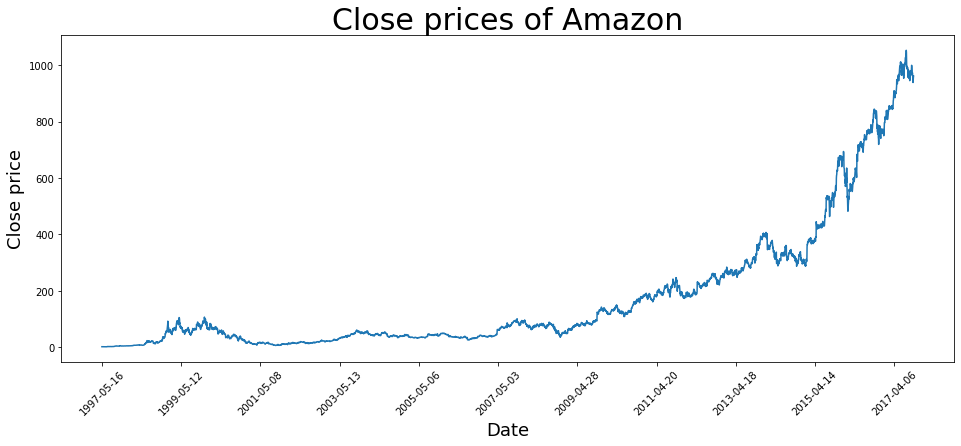

In [7]:
# Ploting the data
plt.figure(figsize = (16,6))
plt.plot(train_data)
plt.xticks(range(0,train_data.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close price',fontsize=18)
plt.title('Close prices of Amazon', fontsize=30)
plt.show()

In [8]:
# Normalizing the data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

# Training the scaler
smoothing_window_size = 500
for di in range(0,3500,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [9]:
# Reshaping train data
train_data = train_data.reshape(-1)

# Normalizing and reshaping test data
test_data = scaler.transform(test_data).reshape(-1)

# Combining data for visualization and test purposes
all_data = np.concatenate([train_data,test_data],axis=0)

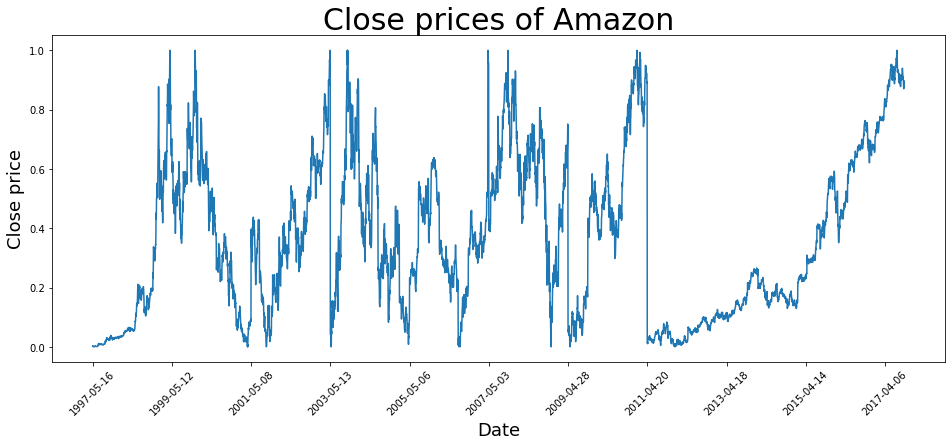

In [10]:
# Ploting the data
plt.figure(figsize = (16,6))
plt.plot(train_data)
plt.xticks(range(0,train_data.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close price',fontsize=18)
plt.title('Close prices of Amazon',fontsize=30)
plt.show()

# One-step prediction via standard average

In [11]:
window_size = 30
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00510


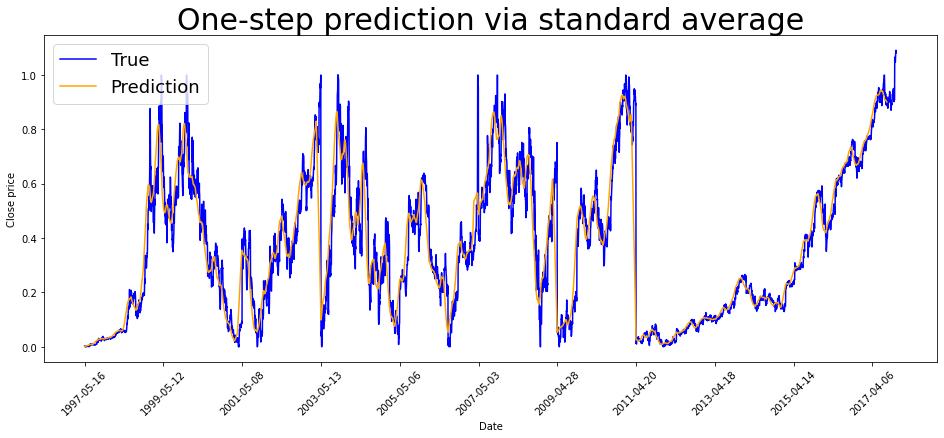

In [12]:
plt.figure(figsize = (16,6))
plt.plot(all_data,color='b',label='True')
plt.plot(std_avg_predictions,color='orange',label='Prediction')
plt.xticks(range(0,all_data.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date')
plt.ylabel('Close price')
plt.title('One-step prediction via standard average', fontsize=30)
plt.legend(fontsize=18)
plt.show()

# One-step prediction via exponential moving average

In [13]:
window_size = 30
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00079


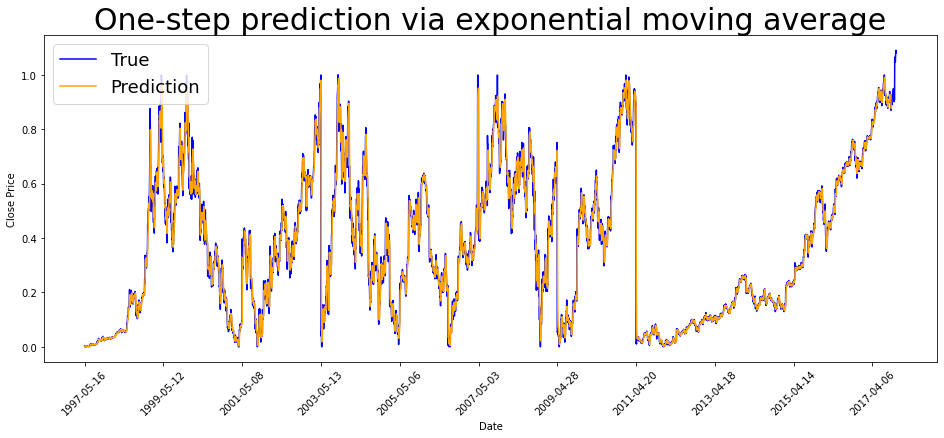

In [14]:
plt.figure(figsize = (16,6))
plt.plot(all_data,color='b',label='True')
plt.plot(run_avg_predictions,color='orange', label='Prediction')
plt.xticks(range(0,all_data.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('One-step prediction via exponential moving average', fontsize=30)
plt.legend(fontsize=18)
plt.show()

# ARIMA

In [15]:
# Import the test
from statsmodels.tsa.stattools import adfuller
# Augmented Dickey-Fuller test for close prices
print("p-value for train data:", adfuller(train_data)[1])

p-value for train data: 0.0005099446868419486


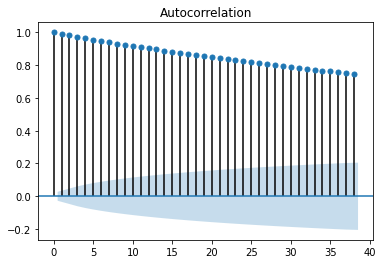

In [16]:
# Autocorrelation
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(train_data);

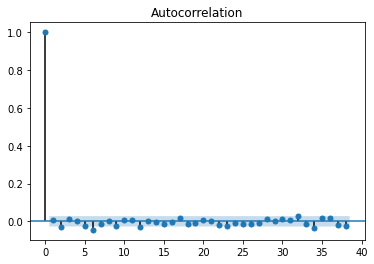

In [17]:
# Autocorrelation on the first difference

first_diff = pd.DataFrame(train_data).diff().dropna()
plot_acf(first_diff);

In the ARIMA model we need to use d = 1 (the first difference). From the same plot we could guess the order of MA term as q =2.

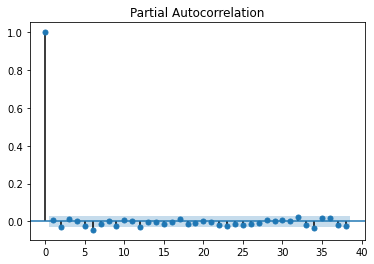

In [18]:
# Partial autocorrelation
from statsmodels.graphics.tsaplots import  plot_pacf

plot_pacf(first_diff);

As the second lag is significant, we could try the order of AR term as p = 6.

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 5122
Model:                 ARIMA(6, 1, 2)   Log Likelihood                9982.062
Method:                       css-mle   S.D. of innovations              0.034
Date:                Thu, 24 Jun 2021   AIC                         -19944.125
Time:                        17:36:58   BIC                         -19878.712
Sample:                             1   HQIC                        -19921.226
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.410      0.682      -0.001       0.001
ar.L1.D.y      0.3325      0.336      0.989      0.323      -0.327       0.992
ar.L2.D.y      0.1519      0.376      0.404      0.6

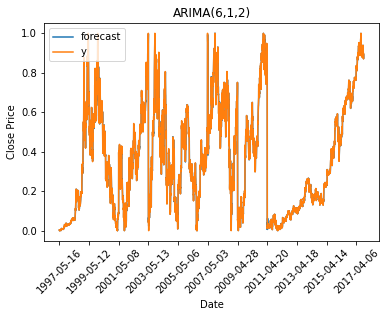

In [19]:
# Training ARIMA model
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_data, order=(6, 1, 2))
model_fit = model.fit()
print(model_fit.summary())

model_fit.plot_predict()
plt.xticks(range(0,train_data.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('ARIMA(6,1,2)')
plt.show()

MSE error for ARIMA(6,1,2): 0.00079


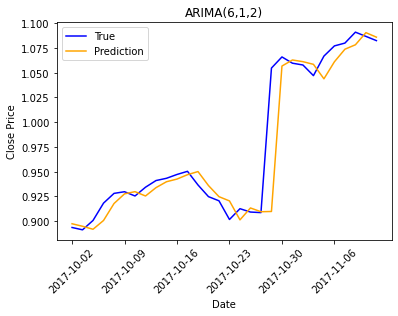

In [20]:
from sklearn.metrics import mean_squared_error
history = [x for x in train_data]
predictions = list()

for t in range(len(test_data)):
	model = ARIMA(history, order=(6,1,2))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test_data[t]
	history.append(obs)
	
mse = mean_squared_error(test_data, predictions)
print('MSE error for ARIMA(6,1,2): %.5f' % mse)

plt.plot(test_data, color = 'b', label = 'True')
plt.plot(predictions, color='orange', label = 'Prediction')
plt.xticks(range(0,test_data.shape[0],5),df['Date'].loc[train_size::5],rotation=45)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('ARIMA(6,1,2)')
plt.legend()
plt.show()

# LSTM (time step = 1)

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPooling1D

In [22]:
#Method to add time_step worth of the nearest values to Tensor object.
def create_LSTM_dataset(dataset, time_step):
    X, Y = [], []
    for i in range(len(dataset)-time_step-1):    
        X.append(dataset[i:(i+time_step), 0])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

#Method to create a LSTM model with 2 layers with 50 neurons each and 1 output layer.
def create_LSTM_model (time_step):
  model=Sequential()
  model.add(LSTM(50, return_sequences=True, input_shape=(1, time_step)))
  model.add(LSTM(50))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.summary()
  return model

In [23]:
time_step = 1

X_train, y_train = create_LSTM_dataset(train_data.reshape(-1,1), time_step)
X_test, y_test = create_LSTM_dataset(test_data.reshape(-1,1), time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , 1)

model = create_LSTM_model(time_step)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

prediction = model.predict(X_test)
train_prediction = model.predict(X_train)

resultsplot = np.concatenate((model.predict(X_train), model.predict(X_test)), axis=0)

train_loss = history.history['loss']
val_loss = history.history['val_loss']

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 50)             10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 5121 samples, validate on 28 samples
Epoch 1/50
5121/5121 [==============================] - 3s 503us/sample - loss: 0.0450 - val_loss: 0.0011
Epoch 2/50
5121/5121 [==============================] -

In [24]:
trainScore = mean_squared_error(y_train, train_prediction)
print('Train Score: %.5f MSE' % (trainScore))

testScore = mean_squared_error(y_test, prediction)
print('Test Score: %.5f MSE' % (testScore))

Train Score: 0.00130 MSE
Test Score: 0.00089 MSE


In [25]:
train_prediction_plot = pd.DataFrame(train_prediction)
train_prediction_plot = train_prediction_plot.shift()

prediction_plot = pd.DataFrame(prediction)
prediction_plot = prediction_plot.shift()

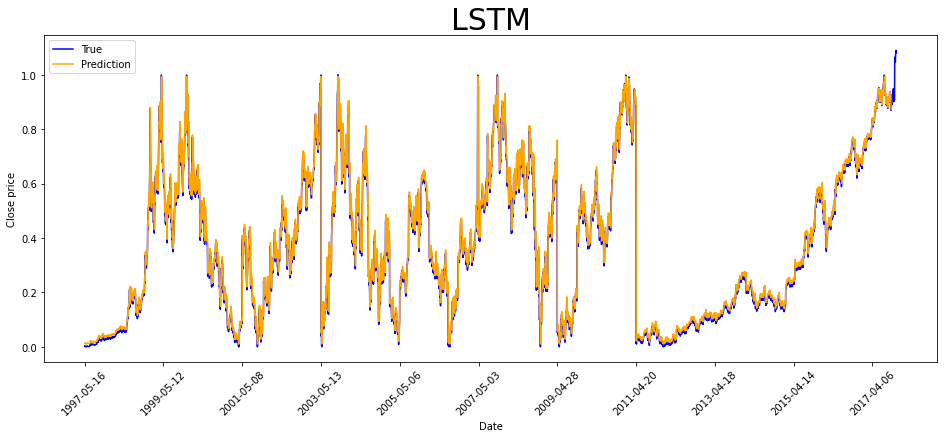

In [26]:
plt.figure(figsize=(16, 6))
plt.plot(all_data, color = 'b', label="True")
plt.plot(train_prediction_plot, color = 'orange', label="Prediction")
plt.xticks(range(0,all_data.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date')
plt.ylabel("Close price")
plt.title('LSTM', fontsize=30)
plt.legend()
plt.show()

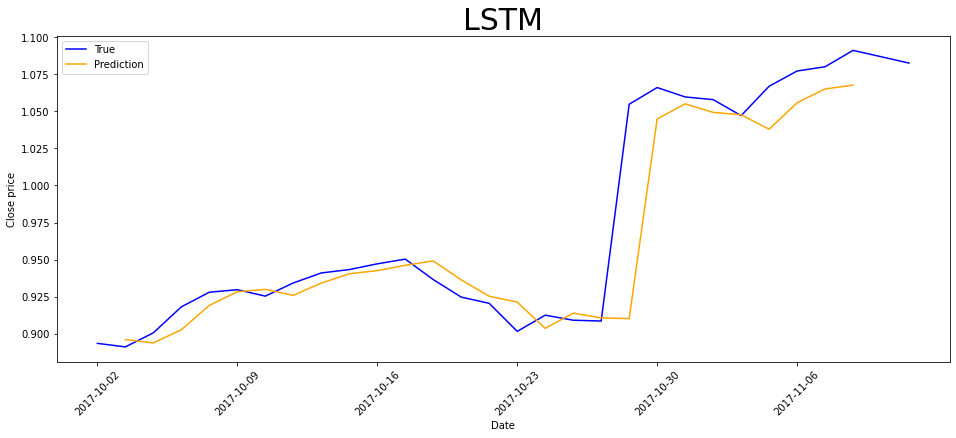

In [27]:
plt.figure(figsize=(16, 6))
plt.plot(test_data, color = 'b', label="True")
plt.plot(prediction_plot, color = 'orange', label="Prediction")
plt.xticks(range(0,test_data.shape[0],5),df['Date'].loc[train_size::5],rotation=45)
plt.ylabel("Close price")
plt.title('LSTM', fontsize=30)
plt.xlabel('Date')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Validation Loss, MSE')

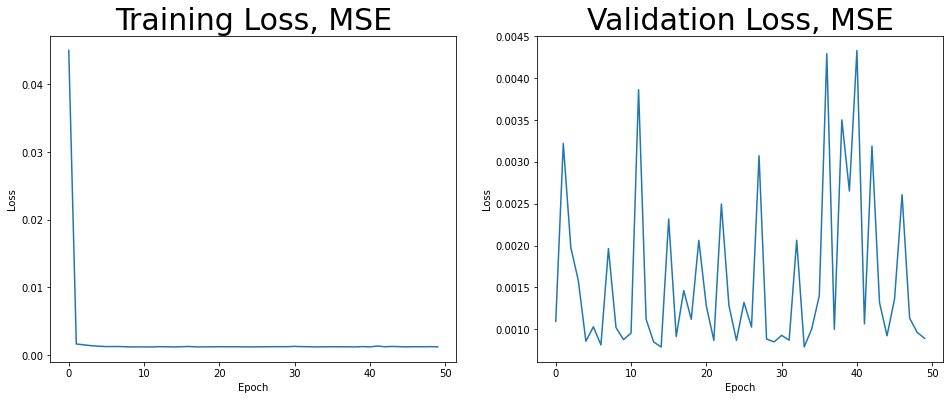

In [28]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss, MSE', fontsize=30)
  
plt.subplot(1, 2, 2)
plt.plot(val_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss, MSE', fontsize=30)